# Getting started with Parcels: general structure

The flexibility of Parcels allows for a wide range of applications and to build complex simulations. In order to help structuring your code, this tutorial describes the structure that a Parcels script uses.

Code that uses Parcels is generally build up from four different components:
1. [**FieldSet**](#1.-FieldSet). Load and set up the fields. These can be velocity fields that are used to advect the particles, but it can also be e.g. temperature.
2. [**ParticleSet**](#2.-ParticleSet). Define the type of particles. Also additional `Variables` can be added to the particles (e.g. temperature, to keep track of the temperature that particles experience).
3. [**Kernels**](#3.-Kernels). Define and compile kernels. Kernels perform some specific operation on the particles every time step (e.g. interpolate the temperature from the temperature field to the particle location).
4. [**Execution and output**](#4.-Execution-and-Output). Execute the simulation and write and store the output in a NetCDF file.

We discuss each component in more detail below.

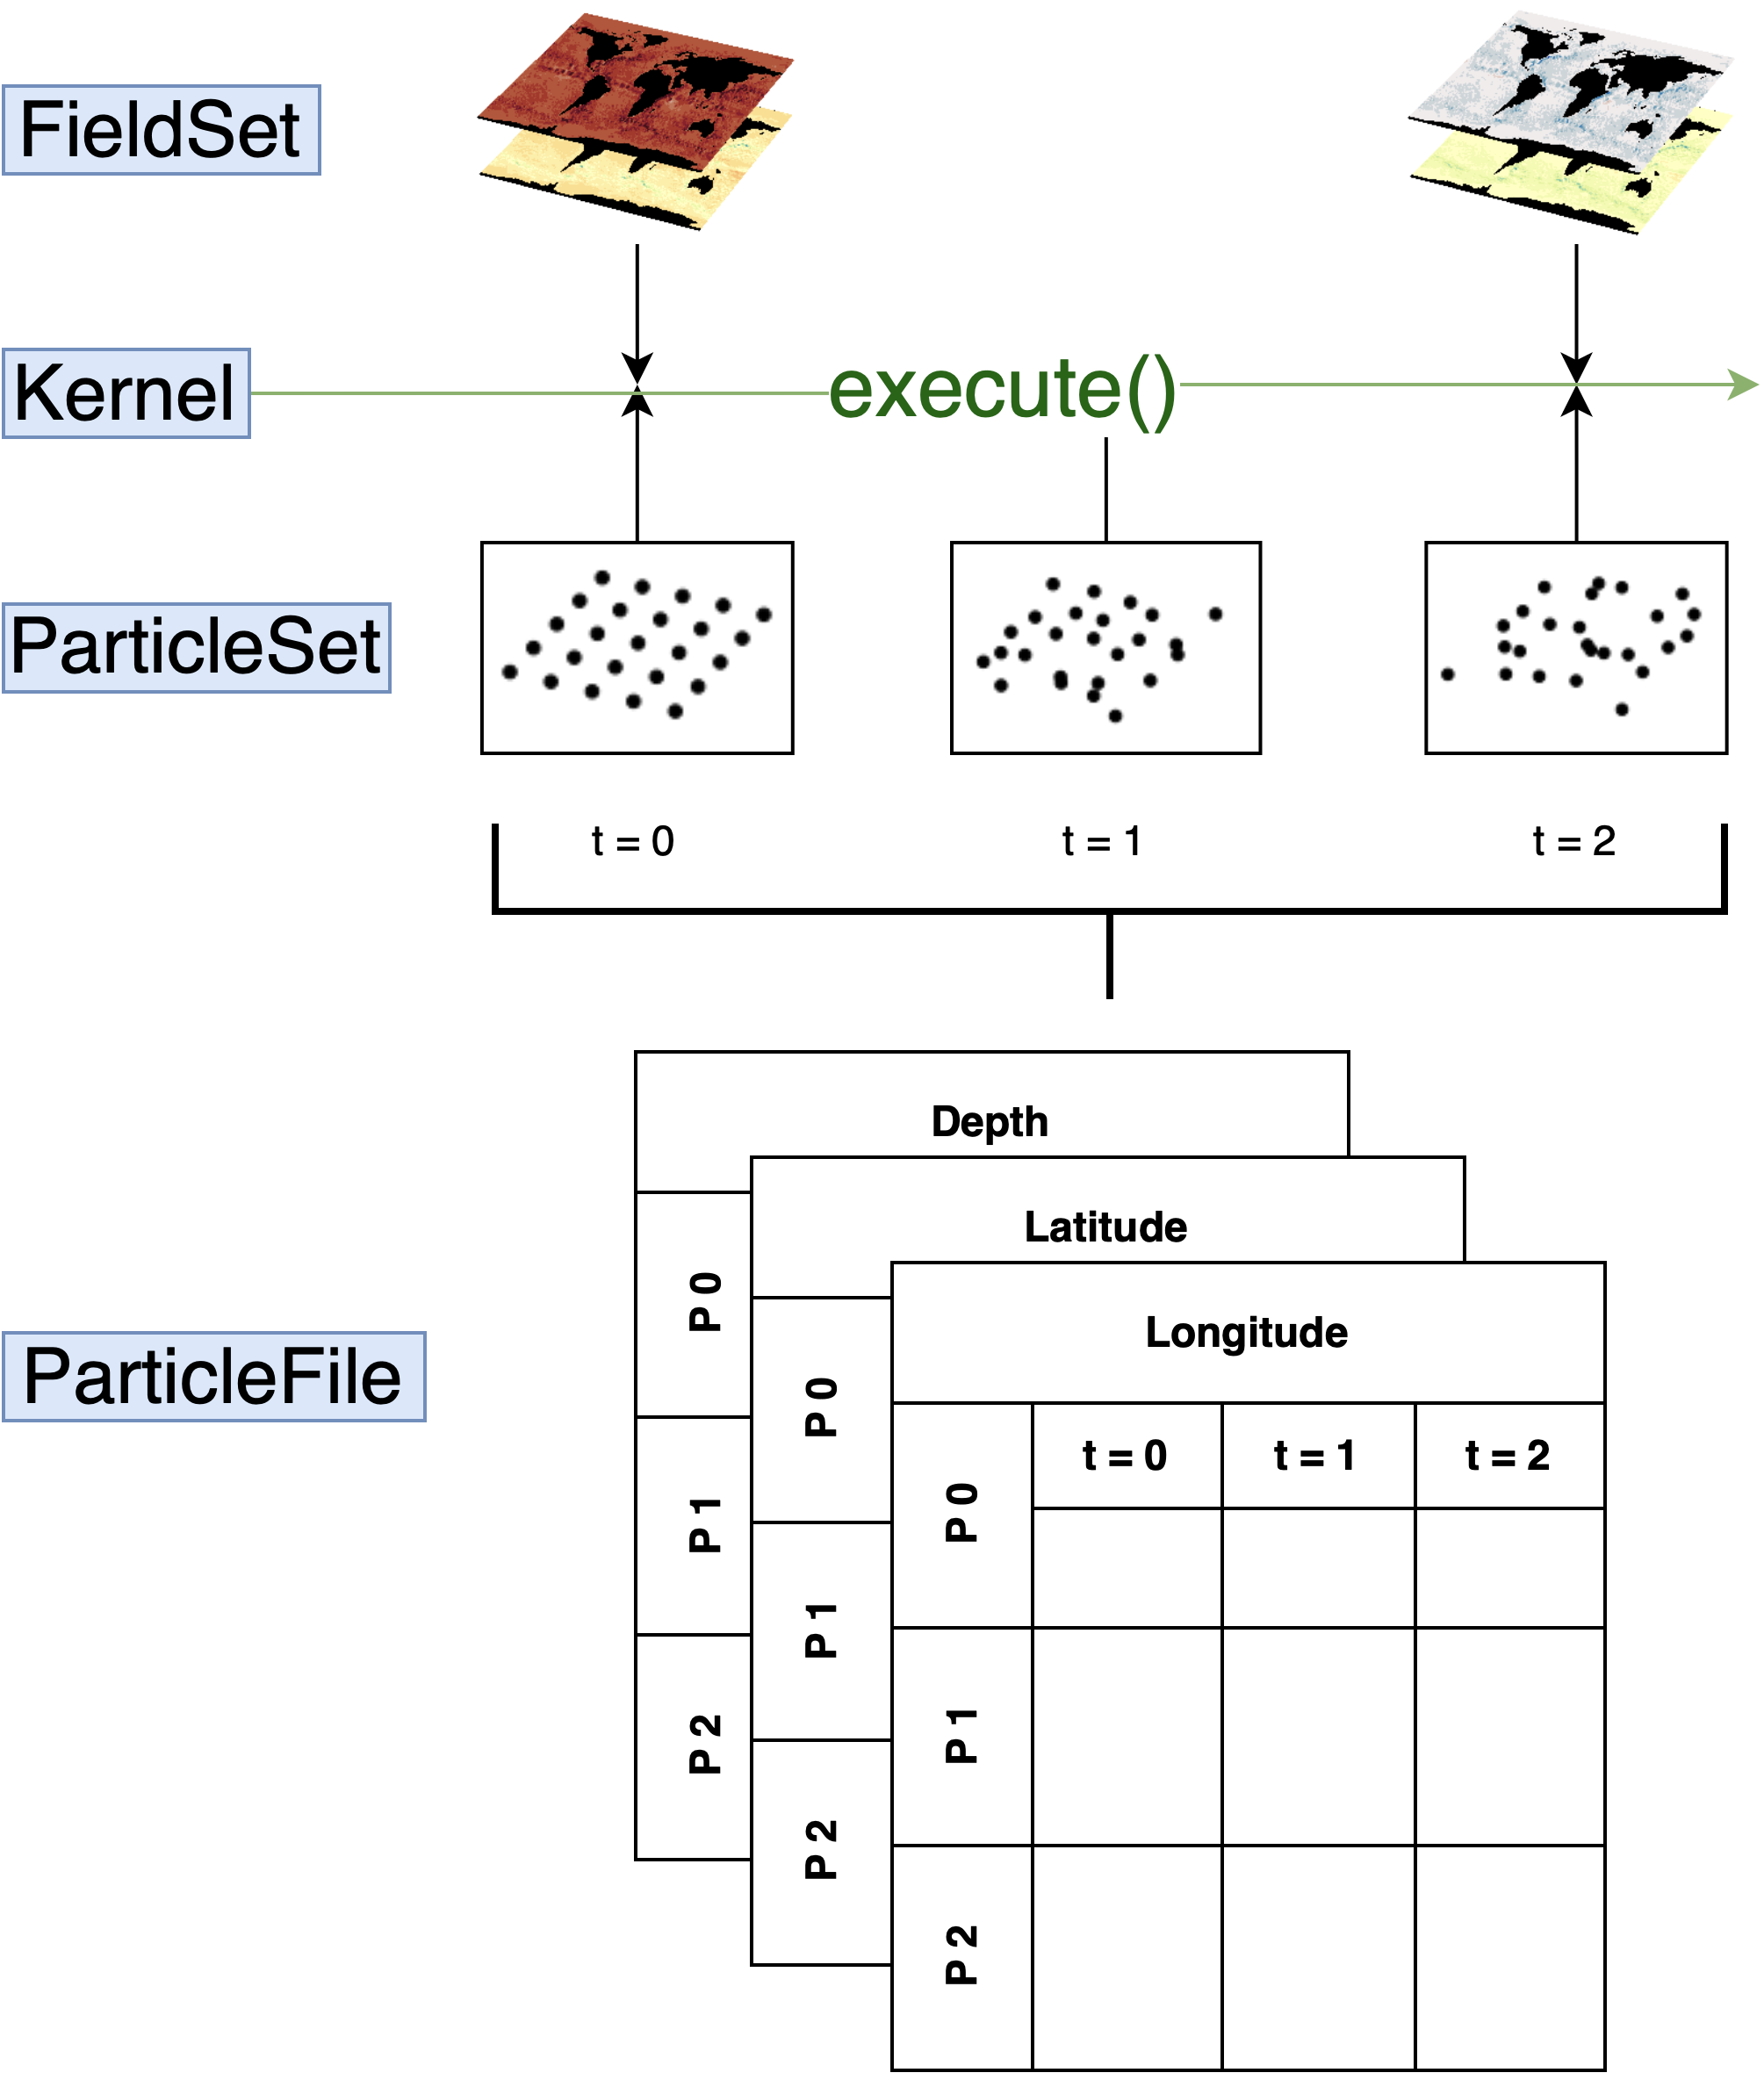

In [1]:
from IPython.display import Image
# Illustration of Parcels code structure
Image(filename='parcels_user_diagram.png', width=500) 

# 1. FieldSet

Parcels provides a framework to simulate the movement of particles **within an existing flow field environment**. To start a parcels simulation we must define this environment with the [**`FieldSet`** class](https://parcels.readthedocs.io/en/latest/reference/fields.html#module-parcels.fieldset). The minimal requirements for this Fieldset are that it must contain the `'U'` and `'V'` fields: the 2D hydrodynamic data that will move the particles in a horizontal direction. Additionally, it can contain e.g. a temperature or vertical flow field.

A fieldset can be loaded with [**`FieldSet.from_netcdf`**](https://parcels.readthedocs.io/en/latest/reference/fields.html#parcels.fieldset.FieldSet.from_netcdf), if the model output with the fields is written in NetCDF files. This function requires `filenames`, `variables` and `dimensions`. 

In this example, we only load the `'U'` and `'V'` fields, which represent the zonal and meridional flow velocity. First, `fname` points to the location of the model output. 

In [2]:
fname = 'GlobCurrent_example_data/*.nc'
filenames = {'U': fname, 'V': fname}

Second, we have to specify the `'U'` and `'V'` variable names, as given by the NetCDF files.

In [3]:
variables = {'U': 'eastward_eulerian_current_velocity', 'V': 'northward_eulerian_current_velocity'}

Third, we specify the names of the variable dimensions, as given by the NetCDF files.

In [4]:
# In the GlobCurrent data the dimensions are also called 'lon', 'lat' and 'time
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}}

Finally, we load the fieldset.

In [5]:
from parcels import FieldSet
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

#### For more advanced tutorials on creating `FieldSets`:

* [Implement **periodic boundaries**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_periodic_boundaries.ipynb)
* [How to **interpolate** field data for different fields](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_interpolation.ipynb)
* [**Converting units** in the field data](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_unitconverters.ipynb)
* [Working around incompatible **time coordinates**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_timestamps.ipynb)

#### If you are working with field data on different grids:
* [Grid **indexing** on different grids](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/documentation_indexing.ipynb)
* [Load field data from **Curvilinear grids**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_nemo_curvilinear.ipynb)
* [Load field data from **3D C-grids**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_nemo_3D.ipynb)

#### If you want to combine different velocity fields:
* [Add different velocity fields in a **SummedField**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_SummedFields.ipynb)
* [Nest velocity fields of different regions or resolutions in a **NestedField**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_NestedFields.ipynb)

# 2. ParticleSet

Once the environment has a `FieldSet` object, you can start defining your particles in a [**`ParticleSet`** object](https://parcels.readthedocs.io/en/latest/reference/particles.html#module-parcels.particleset.particlesetsoa). This object requires:
1. The [**`FieldSet`**](https://parcels.readthedocs.io/en/latest/reference/fields.html#module-parcels.fieldset) object in which the particles will be released.
2. The type of [**`Particle`**](https://parcels.readthedocs.io/en/latest/reference/particles.html#module-parcels.particle): Either a JITParticle or ScipyParticle.
3. Initial conditions for each [**`Variable`**](https://parcels.readthedocs.io/en/latest/reference/particles.html#parcels.particle.Variable) defined in the `Particle`, most notably the release locations in `lon` and `lat`.

In [6]:
from parcels import Variable, JITParticle, ParticleSet

# Define a new particle class
class AgeParticle(JITParticle):        # It is a JIT particle
    age = Variable('age',
                   initial=0)          # Variable 'age' is added with initial value 0.

pset = ParticleSet(fieldset=fieldset,    # the fields that the particleset uses
                   pclass=AgeParticle, # define the type of particle
                   lon=29,               # release longitude
                   lat=-33)              # release latitude

#### For more advanced tutorials on how to setup your `ParticleSet`:
* [**Releasing particles** at different times](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_delaystart.ipynb)
* [The difference between **JITParticles and ScipyParticles**](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_jit_vs_scipy.ipynb)

For more information on how to implement **`Particle` types** with specific behaviour, see the [section on writing your own kernels](#For-more-advanced-tutorials-on-writing-custom-kernels-that-work-on-custom-particles:)

# 3. Kernels

Kernels are little snippets of code, which are applied to every particle in the `ParticleSet`, for every time step during a simulation.
Basic kernels are [included in Parcels](https://parcels.readthedocs.io/en/latest/reference/predefined_kernels.html#predefined-kernels), among which several types of advection kernels. `AdvectionRK4` is the main advection kernel for two-dimensional advection, which is also used in this example.

One can also write custom kernels, to add certain types of 'behaviour' to the particles. Kernels can then be combined with the `+` operator (where at least one of the kernels needs to be cast to a `pset.Kernel()` object), or by creating a `list` of the kernels. Note that the kernels are executed in order.

In [7]:
# load basic advection kernels
from parcels import AdvectionRK4

# Create a custom kernel which displaces each particle southward
def NorthVel(particle, fieldset, time):
    if time > 10*86400 and time < 10.2*86400:
        vvel = -1e-4
        particle.lat += vvel * particle.dt
        
# Create a custom kernel which keeps track of the particle age (minutes)
def Age(particle, fieldset, time):
    particle.age += particle.dt / 3600

# define all kernels to be executed on particles using an (ordered) list
kernels = [Age, NorthVel, AdvectionRK4]

<a id="kernelrules"></a>
Some key limitations exist to the Kernels that everyone who wants to write their own should be aware of:
* Every Kernel must be a function with the following (and only those) arguments: `(particle, fieldset, time)`
* In order to run successfully in JIT mode, Kernel definitions can only contain the following types of commands:
    * Basic arithmetical operators (`+`, `-`, `*`, `/`, `**`) and assignments (`=`).
    * Basic logical operators (`<`, `==`, `!=`, `>`, `&`, `|`). Note that you can use a statement like `particle.lon != particle.lon` to check if `particle.lon` is NaN (since `math.nan != math.nan`).
    * `if` and `while` loops, as well as `break` statements. Note that `for`-loops are not supported in JIT mode.
    * Interpolation of a `Field` from the `FieldSet` at a `[time, depth, lat, lon]` point, using square brackets notation.
    For example, to interpolate the zonal velocity (U) field at the particle location, use the following statement:
    `value = fieldset.U[time, particle.depth, particle.lat, particle.lon]`
    * Functions from the `math` standard library and from the custom `ParcelsRandom` library at [`parcels.rng`](https://parcels.readthedocs.io/en/latest/reference/misc.html#module-parcels.rng)
    * Simple `print` statements, such as:
        * `print("Some print")`
        * `print(particle.lon)`
        * `print(f"particle id: {particle.id}")`
        * `print(f"lon: {particle.lon}, lat: {particle.lat}")`
    
      Although note that these `print` statements are not shown in Jupyter notebooks in JIT mode, see [this long-standing Issue](https://github.com/OceanParcels/parcels/issues/369).
    * Local variables can be used in Kernels, and these variables will be accessible in all concatenated Kernels. Note that these local variables are not shared between particles, and also not between time steps.
    * Note that one has to be careful with writing kernels for vector fields on Curvilinear grids. While Parcels automatically rotates the U and V field when necessary, this is not the case for for example wind data. In that case, a custom rotation function will have to be written.

#### For more advanced tutorials on writing custom kernels that work on custom particles:
* [Sample other fields like temperature](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_sampling.ipynb).
* [Mimic the behavior of ARGO floats](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_Argofloats.ipynb).
* [Adding diffusion to approximate subgrid-scale processes and unresolved physics](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_diffusion.ipynb).
* [Converting between units in m/s and degree/s](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_unitconverters.ipynb).

# 4. Execution and output

The final part executes the simulation, given the `ParticleSet`, `FieldSet` and `Kernels`, that have been defined in the previous steps. If you like to store the particle data generated in the simulation, you define the [**`ParticleFile`**](https://parcels.readthedocs.io/en/latest/reference/particlefile.html#particlefile) to which the output of the kernel execution will be written. Then, on the [`ParticleSet`](#ParticleSet) you have defined, you can use the method [**`ParticleSet.execute()`**](https://parcels.readthedocs.io/en/latest/reference/particles.html#parcels.particleset.baseparticleset.BaseParticleSet.execute) which requires the following arguments:
1. The kernels to be executed.
2. The `runtime` defining how long the execution loop runs. Alternatively, you may define the `endtime` at which the execution loop stops.
3. The timestep `dt` at which to execute the kernels.
4. (Optional) The `ParticleFile` object to write the output to.

In [8]:
output_file = pset.ParticleFile(name="GCParticles.zarr", outputdt=3600) # the file name and the time step of the outputs

pset.execute(kernels,                 # the kernel (which defines how particles move)
             runtime=86400*24,        # the total length of the run in seconds
             dt=300,                  # the timestep of the kernel in seconds
             output_file=output_file)

INFO: Compiled ArrayAgeParticleAgeNorthVelAdvectionRK4 ==> /var/folders/s5/gxtkk3c12yqgd7hkt1b_s0vr0000gq/T/parcels-503/lib0e6e33cfac25b37419e8147f88e31705_0.so


After running your simulation, you probably want to analyse the output. Although there is some simple plotting functionality built into Parcels, we **recommend you write your own code** to analyse your specific output and you can probably separate the analysis from the simulation. 
#### For more tutorials on the parcels output:
* [How the output is structured and how to start your own analysis](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/docs/examples/tutorial_output.ipynb)